In [2]:
import control
import pyhull
import string
import picos as pic
import cvxopt as cvx
import math
import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.integrate
import itertools
import sympy
import sympy.physics.mechanics as me
import sys
from matplotlib.patches import Ellipse
from pylab import*
from pytope import Polytope
from scipy.spatial import ConvexHull
from __future__ import division

In [3]:
def traj(x0, u, omega, t):
    
    n_steps = len(t)
    dt = t[1]-t[0]

    # initial condition
    xs = x0
    out_xr = []
    
    tc = n_steps/(omega_t.shape[0]) # time of changing velocity
    
    for i in range(n_steps):
        
        # change of velocity
        if i % tc == 0:
            w = omega[int(i//tc)] #ut[int(i//tc*2)+1]
            if w == 0:
                v = u
            else:
                v = 1
        
        # store data
        out_xr.append(xs) # reference trajectory
        # Propagate reference
        xs = xs + dt*np.array([v*cos(xs[2]), v*sin(xs[2]), w])


    x = np.array(out_xr)
    return x

In [4]:
class MyConvexHull(object):
    
    def __init__(self, res=None, eqs=None, points=None, facets=None, max_dist=None):
        self.res = res
        self.eqs = eqs
        self.points = points
        self.facets = facets
        self.max_dist = max_dist

    @classmethod
    def from_points(cls, points, angle=0.99):
        res = pyhull.qconvex('n i A{:f} Fs'.format(angle), points)
        n_dim = int(res[0])-1
        n_eqs = int(res[1])
        eqs = array([line.split() for line in res[2:2+n_eqs]]).astype(float)
        n_facets = int(res[2+n_eqs])
        facets = array([line.split() for line in res[3+n_eqs:3+n_eqs+n_facets]]).astype(int)
        max_dist = float(res[4+n_eqs+n_facets].split()[1])
        return cls(res, eqs, points, facets, max_dist)
    
    @classmethod
    def from_halfspaces(cls, interior_point, halfspaces):
        s = 'H'
        for i in range(len(interior_point)):
            s += '{:5g},'.format(interior_point[i])
        opt = s + ' Fp'
        res = pyhull.qhull_cmd('qhalf', opt, halfspaces)
        n_dim = int(res[0])
        n_vert = int(res[1])
        points = array([line.split() for line in res[2:2+n_vert]]).astype(float)
        return cls.from_points(points)
    
    def add_buffer(self, b):
        self.eqs[:,-1] -= b
        s = zeros(self.points[0].shape)
        interior_point = self.points.mean(0)
        return MyConvexHull.from_halfspaces(interior_point, self.eqs)
    
    def __repr__(self):
        return string.join(self.res, '\n')
    
    def contains(self, p):
        return False

In [5]:
def dynamics(t, y_vect):
    X_r = SE2(x=y_vect[3], y=y_vect[4], theta=y_vect[5])
    
    # reference input
    v_r = se2(x=1, y=0, theta=0.01087*(1 - np.cos(2*np.pi*t*0.1))**6)
    
    return [
        # reference
        v_r.x*np.cos(X_r.theta),
        v_r.x*np.sin(X_r.theta),
        v_r.theta
    ]

In [6]:
def minimum_bounding_rectangle(points):
    """
    Find the smallest bounding rectangle for a set of points.
    Returns a set of points representing the corners of the bounding box.

    :param points: an nx2 matrix of coordinates
    :rval: an nx2 matrix of coordinates
    """
    from scipy.ndimage.interpolation import rotate
    pi2 = np.pi/2.

    # get the convex hull for the points
    hull_points = points[ConvexHull(points).vertices]

    # calculate edge angles
    edges = np.zeros((len(hull_points)-1, 2))
    edges = hull_points[1:] - hull_points[:-1]

    angles = np.zeros((len(edges)))
    angles = np.arctan2(edges[:, 1], edges[:, 0])

    angles = np.abs(np.mod(angles, pi2))
    angles = np.unique(angles)

    # find rotation matrices
    # XXX both work
    rotations = np.vstack([
        np.cos(angles),
        np.cos(angles-pi2),
        np.cos(angles+pi2),
        np.cos(angles)]).T
#     rotations = np.vstack([
#         np.cos(angles),
#         -np.sin(angles),
#         np.sin(angles),
#         np.cos(angles)]).T
    rotations = rotations.reshape((-1, 2, 2))

    # apply rotations to the hull
    rot_points = np.dot(rotations, hull_points.T)

    # find the bounding points
    min_x = np.nanmin(rot_points[:, 0], axis=1)
    max_x = np.nanmax(rot_points[:, 0], axis=1)
    min_y = np.nanmin(rot_points[:, 1], axis=1)
    max_y = np.nanmax(rot_points[:, 1], axis=1)

    # find the box with the best area
    areas = (max_x - min_x) * (max_y - min_y)
    best_idx = np.argmin(areas)

    # return the best box
    x1 = max_x[best_idx]
    x2 = min_x[best_idx]
    y1 = max_y[best_idx]
    y2 = min_y[best_idx]
    r = rotations[best_idx]

    rval = np.zeros((4, 2))
    rval[0] = np.dot([x1, y2], r)
    rval[1] = np.dot([x2, y2], r)
    rval[2] = np.dot([x2, y1], r)
    rval[3] = np.dot([x1, y1], r)

    return rval

In [7]:
def minBoundingRect(hull_points_2d):
    #print "Input convex hull points: "
    #print hull_points_2d

    # Compute edges (x2-x1,y2-y1)
    edges = zeros( (len(hull_points_2d)-1,2) ) # empty 2 column array
    for i in range( len(edges) ):
        edge_x = hull_points_2d[i+1,0] - hull_points_2d[i,0]
        edge_y = hull_points_2d[i+1,1] - hull_points_2d[i,1]
        edges[i] = [edge_x,edge_y]
    #print "Edges: \n", edges

    # Calculate edge angles   atan2(y/x)
    edge_angles = zeros( (len(edges)) ) # empty 1 column array
    for i in range( len(edge_angles) ):
        edge_angles[i] = math.atan2( edges[i,1], edges[i,0] )
    #print "Edge angles: \n", edge_angles

    # Check for angles in 1st quadrant
    for i in range( len(edge_angles) ):
        edge_angles[i] = abs( edge_angles[i] % (math.pi/2) ) # want strictly positive answers
    #print "Edge angles in 1st Quadrant: \n", edge_angles

    # Remove duplicate angles
    edge_angles = unique(edge_angles)
    #print "Unique edge angles: \n", edge_angles

    # Test each angle to find bounding box with smallest area
    min_bbox = (0, sys.maxsize, 0, 0, 0, 0, 0, 0) # rot_angle, area, width, height, min_x, max_x, min_y, max_y
    #print("Testing", len(edge_angles), "possible rotations for bounding box... \n")
    for i in range( len(edge_angles) ):

        # Create rotation matrix to shift points to baseline
        # R = [ cos(theta)      , cos(theta-PI/2)
        #       cos(theta+PI/2) , cos(theta)     ]
        R = array([ [ math.cos(edge_angles[i]), math.cos(edge_angles[i]-(math.pi/2)) ], [ math.cos(edge_angles[i]+(math.pi/2)), math.cos(edge_angles[i]) ] ])
        #print "Rotation matrix for ", edge_angles[i], " is \n", R

        # Apply this rotation to convex hull points
        rot_points = dot(R, transpose(hull_points_2d) ) # 2x2 * 2xn
        #print "Rotated hull points are \n", rot_points

        # Find min/max x,y points
        min_x = nanmin(rot_points[0], axis=0)
        max_x = nanmax(rot_points[0], axis=0)
        min_y = nanmin(rot_points[1], axis=0)
        max_y = nanmax(rot_points[1], axis=0)
        #print "Min x:", min_x, " Max x: ", max_x, "   Min y:", min_y, " Max y: ", max_y

        # Calculate height/width/area of this bounding rectangle
        width = max_x - min_x
        height = max_y - min_y
        area = width*height
        #print "Potential bounding box ", i, ":  width: ", width, " height: ", height, "  area: ", area 

        # Store the smallest rect found first (a simple convex hull might have 2 answers with same area)
        if (area < min_bbox[1]):
            min_bbox = ( edge_angles[i], area, width, height, min_x, max_x, min_y, max_y )
        # Bypass, return the last found rect
        #min_bbox = ( edge_angles[i], area, width, height, min_x, max_x, min_y, max_y )

    # Re-create rotation matrix for smallest rect
    angle = min_bbox[0]   
    R = array([ [ math.cos(angle), math.cos(angle-(math.pi/2)) ], [ math.cos(angle+(math.pi/2)), math.cos(angle) ] ])
    #print "Projection matrix: \n", R

    # Project convex hull points onto rotated frame
    proj_points = dot(R, transpose(hull_points_2d) ) # 2x2 * 2xn
    #print "Project hull points are \n", proj_points

    # min/max x,y points are against baseline
    min_x = min_bbox[4]
    max_x = min_bbox[5]
    min_y = min_bbox[6]
    max_y = min_bbox[7]
    #print "Min x:", min_x, " Max x: ", max_x, "   Min y:", min_y, " Max y: ", max_y

    # Calculate center point and project onto rotated frame
    center_x = (min_x + max_x)/2
    center_y = (min_y + max_y)/2
    center_point = dot( [ center_x, center_y ], R )
    #print "Bounding box center point: \n", center_point

    # Calculate corner points and project onto rotated frame
    corner_points = zeros( (4,2) ) # empty 2 column array
    corner_points[0] = dot( [ max_x, min_y ], R )
    corner_points[1] = dot( [ min_x, min_y ], R )
    corner_points[2] = dot( [ min_x, max_y ], R )
    corner_points[3] = dot( [ max_x, max_y ], R )
    #print "Bounding box corner points: \n", corner_points

    #print "Angle of rotation: ", angle, "rad  ", angle * (180/math.pi), "deg"

    return (angle, min_bbox[1], min_bbox[2], min_bbox[3], center_point, corner_points) # rot_angle, area, width, height, center_point, corner_points

In [8]:
link = lambda a,b: concatenate((a,b[1:]))
edge = lambda a,b: concatenate(([a],[b]))

def qhull2D(sample):
    def dome(sample,base): 
        h, t = base
        dists = dot(sample-h, dot(((0,-1),(1,0)),(t-h)))
        outer = repeat(sample, dists>0, 0)
        if len(outer):
            pivot = sample[argmax(dists)]
            return link(dome(outer, edge(h, pivot)),
                    dome(outer, edge(pivot, t)))
        else:
            return base
    if len(sample) > 2:
        axis = sample[:,0]
        base = take(sample, [argmin(axis), argmax(axis)], 0)
        return link(dome(sample, base), dome(sample, base[::-1]))
    else:
        return sample

In [9]:
def create_flow_tube(y, r, t):

    bound = r*ones(len(t)).reshape(len(t),1) # 1000*1
    #t, y, x = control.forced_response(sys, T=t, U=u, X0=x0)

    nom = y[:,0:2] # nominal trajecotry 1000*2
    
    #bounds
    p = array([
        nom + bound.dot(array([[1,1]])), 
        nom + bound.dot(array([[-1,1]])),
        nom + bound.dot(array([[1,-1]])),
        nom + bound.dot(array([[-1,-1]]))
    ])

    # space using arclength
    n_steps = 100
    arc_length = cumsum(norm(array([diff(nom[:,0]),diff(nom[:,1])]), axis=0))
    norm_arc_length = arc_length/arc_length[-1]
    i_steps = array([np.where(norm_arc_length >= per)[0] for per in linspace(0,1,n_steps)])

    # find convex sets
    flow_tube = []
    for i in range(n_steps-1):
        i0 = i_steps[i][0]
        i1 = i_steps[i+1][0]+1
        step = i1-i0
        p_i = reshape(p[:,i0:i1,:], [p.shape[0]*step,p.shape[2]])
        ch = MyConvexHull.from_points(p_i, angle=0.99)
        ch = ch.add_buffer(ch.max_dist)
        flow_tube.append(ch)
    return flow_tube, nom

In [10]:
def flowpipes(y, r, t, n):
    nom = y[:,0:2] # n*2 (x-y direction)
    
    # bound 
    theta_circ = np.linspace(0, 2*np.pi, 100)
    circ = array([r*np.cos(theta_circ), r*np.sin(theta_circ)]).T
    P2 = Polytope(circ) # invariant set
    
    flowpipes = []
    intervalhull = []
    steps = int(len(t)/n)
    
    for i in range(n):
        # get traj for certain fixed time interval
        nom_i = nom[steps*i:steps*(i+1),:] # steps*2
        
        # Get interval hull
        hull_points = qhull2D(nom_i)
        # Reverse order of points, to match output from other qhull implementations
        hull_points = hull_points[::-1]
        (rot_angle, area, width, height, center_point, corner_points) = minBoundingRect(hull_points)
        
        # minkowski sum
        P1 = Polytope(corner_points) # interval hull
        P = P1+P2 # sum
        p1_vertices = P1.V
        p_vertices = P.V
        flowpipes.append(p_vertices)
        intervalhull.append(p1_vertices)
    return flowpipes, intervalhull, nom

In [11]:
v = 5
omega = pi/4
x0 = np.array([0,0,0])
ut = v
omega_t = np.array([0,omega,0,omega,0,omega,0,omega])
t = linspace(0,16,1600)
n = 10

TEB = 1.476 # HJB w/ control bound [-pi,pi]
r_small = 1.4487 # lyapunov w/ small theta_max
r_large = 2.1136 # lyapunov w/ large theta_max


xr = traj(x0, ut, omega_t, t)

#flow_tube_small, nom_small = create_flow_tube(xr, 0, t)
#flow_tube_large, nom_large = create_flow_tube(xr, 0.5, t)
#flow_tube_TEB, nom_TEB = create_flow_tube(xr, TEB, t)

flow_pipes_s, intervalhull_s, nom = flowpipes(xr,r_small,t, n)
flow_pipes_l, intervalhull_l, nom = flowpipes(xr,r_large,t, n)
flow_pipes_H, intervalhull_H, nom = flowpipes(xr,TEB,t, n)



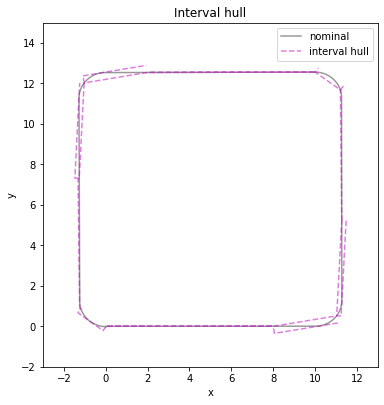

In [12]:
plt.figure(figsize=(9/1.5,9.5/1.5))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-', alpha = 0.4)
for facet in range(n):
    hs_ch_s = ax.plot(intervalhull_s[facet][:,0], intervalhull_s[facet][:,1], color='m', linestyle='--', alpha =0.5)
    #hs_ch_l = ax.plot(intervalhull_l[facet][:,0], intervalhull_l[facet][:,1], color='y', linestyle='--')


title('Interval hull')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_s[0]], ['nominal', 'interval hull'], loc=1);
plt.xlim([-3, 13]);
plt.ylim([-2, 15]);



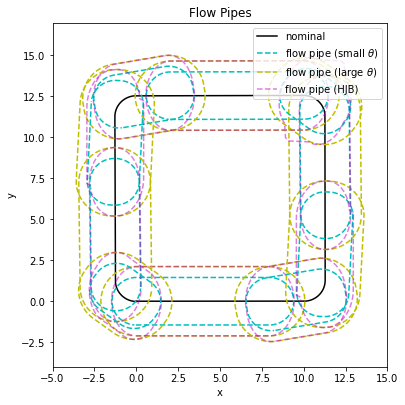

In [13]:
plt.figure(figsize=(9/1.5,9.5/1.5))
ax = subplot(111)
h_nom = ax.plot(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_s = ax.plot(flow_pipes_s[facet][:,0], flow_pipes_s[facet][:,1], color='c', linestyle='--')
    hs_ch_l = ax.plot(flow_pipes_l[facet][:,0], flow_pipes_l[facet][:,1], color='y', linestyle='--')
    hs_ch_H = ax.plot(flow_pipes_H[facet][:,0], flow_pipes_l[facet][:,1], color='m', linestyle='--', alpha = 0.5)

title('Flow Pipes')
xlabel('x')
ylabel('y')
legend([h_nom[0], hs_ch_s[0], hs_ch_l[0], hs_ch_H[0]], ['nominal', 'flow pipe (small $\\theta$)', 'flow pipe (large $\\theta$)','flow pipe (HJB)'], loc=1);
plt.xlim([-5, 15]);
plt.ylim([-4, 17]);

In [14]:
from math import pi, cos, sin, sqrt
from pyobb.obb import OBB

# creates a lat/lon sphere with a given radius and centered at a given point
def sphere(radius, center, num_slices=30):
    theta_step = 2.0 * pi / (num_slices - 1)
    phi_step = pi / (num_slices - 1.0)
    theta = 0.0
    vertices = []
    for i in range(0, num_slices):
        cos_theta = cos(theta)
        sin_theta = sin(theta)
        phi = 0.0
        for j in range(0, num_slices):
            x = -sin(phi) * cos_theta
            y = -cos(phi)
            z = -sin(phi) * sin_theta
            n = sqrt(x * x + y * y + z * z)
            if n < 0.99 or n > 1.01:
                x /= n
                y /= n
                z /= n
            vertices.append((x * radius + center[0],
                             y * radius + center[1],
                             z * radius + center[2]))
            phi += phi_step
        theta += theta_step
    return vertices

obb = OBB.build_from_points(sphere(1, (0, 0, 0)))

In [15]:
pts = array([[0,0,0],[0,0.2,0],[0,0.4,0],[0,0.6,0],[0,0.8,0],[0,1,0]])

In [16]:
obb = OBB.build_from_points(pts)

In [17]:
x=[]
y=[]
z=[]
for i in range (len(obb.points)):
    x.append(obb.points[i][0])
    y.append(obb.points[i][1])
    z.append(obb.points[i][2])

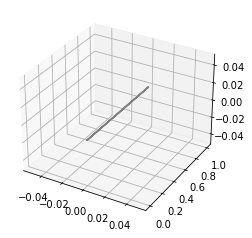

In [18]:
fig = plt.figure(4)
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(x, y, z, 'gray')

In [19]:
obb.points

[array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 1., 0.]),
 array([0., 1., 0.]),
 array([0., 0., 0.]),
 array([0., 0., 0.]),
 array([0., 1., 0.]),
 array([0., 1., 0.])]

In [20]:
points = zeros((16,3))

In [21]:
def box(obb):
    points = zeros((16,3))
    points[0] = obb.points[0]
    points[1] = obb.points[1]
    points[2] = obb.points[2]
    points[3] = obb.points[3]
    points[4] = obb.points[0]
    points[5] = obb.points[5]
    points[6] = obb.points[4]
    points[7] = obb.points[7]
    points[8] = obb.points[6]
    points[9] = obb.points[5]
    points[10] = obb.points[4]
    points[11] = obb.points[1]
    points[12] = obb.points[2]
    points[13] = obb.points[7]
    points[14] = obb.points[6]
    points[15] = obb.points[3]
    return points

In [22]:
p = box(obb)
x1=[]
y1=[]
z1=[]
for i in range (len(points)):
    x1.append(p[i,0])
    y1.append(p[i,1])
    z1.append(p[i,2])

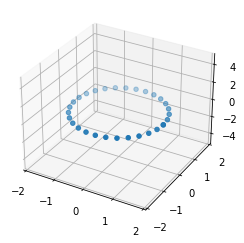

In [27]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(circ[:,0],circ[:,1],circ[:,2])
#ax.plot3D(x1, y1, z1, 'grey')
xlim(-2,2)
ylim(-2,2)
ax.set_zlim(-5, 5)
plt.show()

In [28]:
P1 = Polytope(obb.points)

In [29]:
# bound 
theta_circ = np.linspace(0, 2*np.pi, 30)
circ = array([ 1.5*np.cos(theta_circ), 1.5*np.sin(theta_circ),0*ones(30)]).T

In [30]:
P2 = Polytope(circ)#@obb.rotation)

In [31]:
P = P2

In [32]:
c= circ

In [33]:
def flowpipes3d(y, r, t, n):
    nom = np.append(y[:,0:2],zeros((y.shape[0],1)), axis = 1) # n*3 (x-y direction) ###########
    
    # bound 
    theta_circ = np.linspace(0, 2*np.pi, 30)
    circ = array([1.5*np.cos(theta_circ), 1.5*np.sin(theta_circ), ones(30)]).T # circle in 3D
    
    flowpipes = []
    intervalhull = []
    steps = int(len(t)/n)
    
    for i in range(n):
        # get traj for certain fixed time interval
        nom_i = nom[steps*i:steps*(i+1),:] # steps*3
        
        # interval hull
        obb = OBB.build_from_points(nom_i)
        
        # minkowski sum
        P1 = Polytope(obb.points) # interval hull
        P2 = Polytope(circ) # invariant set
        print(P1.V)
        P = P1+P2 # sum
        
        p1_vertices = P1.V
        p_vertices = P.V
        flowpipes.append(p_vertices)
        intervalhull.append(p1_vertices)
        
    return flowpipes, intervalhull, nom

In [35]:
n = 7
flow_pipes3d_s, intervalhull_s, nom = flowpipes3d(xr,0,t, n)

[[ 0.00000000e+00  7.12384522e-09 -1.39972378e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.02745108e+01  0.00000000e+00  0.00000000e+00]
 [ 1.02745108e+01  7.12384522e-09 -1.39972378e-05]
 [ 0.00000000e+00  2.75023756e-02  1.39972378e-05]
 [ 0.00000000e+00  2.75023828e-02  1.69406589e-21]
 [ 1.02745108e+01  2.75023828e-02  1.69406589e-21]
 [ 1.02745108e+01  2.75023756e-02  1.39972378e-05]]
[[10.28429261  0.19945398  0.80566835]
 [10.28429261  4.02119914  0.        ]
 [11.28449433  4.02119914  0.        ]
 [11.28449433  0.19945398  0.80566835]
 [10.28429261  3.85135487 -0.80566835]
 [10.28429261  0.02960971  0.        ]
 [11.28449433  0.02960971  0.        ]
 [11.28449433  3.85135487 -0.80566835]]
[[ 1.10155428e+01  4.07123038e+00 -6.93889390e-18]
 [ 1.10155428e+01  1.20476864e+01  1.15650747e-01]
 [ 1.12817420e+01  1.20476864e+01  1.15650747e-01]
 [ 1.12817420e+01  4.07123038e+00 -6.93889390e-18]
 [ 1.10155428e+01  1.20493633e+01  0.00000000e+00]
 [ 1.10155428e+01  4.07

Text(0.5, 0, 'y')

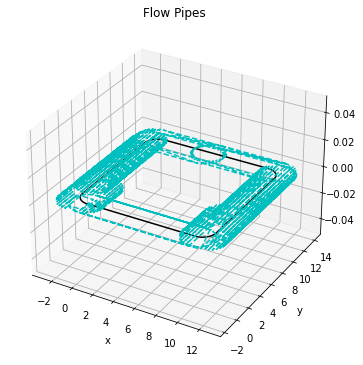

In [36]:
plt.figure(figsize=(9/1.5,9.5/1.5))
ax = plt.axes(projection='3d')
h_nom = ax.plot3D(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_s = ax.plot3D(flow_pipes3d_s[facet][:,0], flow_pipes3d_s[facet][:,1], color='c', linestyle='--')
    #hs_ch_l = ax.plot(flow_pipes_l[facet][:,0], flow_pipes_l[facet][:,1], color='y', linestyle='--')
    #hs_ch_H = ax.plot(flow_pipes_H[facet][:,0], flow_pipes_l[facet][:,1], color='m', linestyle='--', alpha = 0.5)

title('Flow Pipes')
xlabel('x')
ylabel('y')
#legend([h_nom[0], hs_ch_s[0], hs_ch_l[0], hs_ch_H[0]], ['nominal', 'flow pipe (small $\\theta$)', 'flow pipe (large $\\theta$)','flow pipe (HJB)'], loc=1);
#plt.xlim([-5, 15]);
#plt.ylim([-4, 17]);

Text(0.5, 0, 'y')

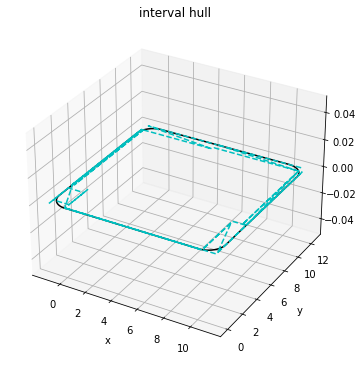

In [37]:
plt.figure(figsize=(9/1.5,9.5/1.5))
ax = plt.axes(projection='3d')
h_nom = ax.plot3D(nom[:,0], nom[:,1], color='k', linestyle='-')
for facet in range(n):
    hs_ch_s = ax.plot3D(intervalhull_s[facet][:,0], intervalhull_s[facet][:,1], color='c', linestyle='--')

title('interval hull')
xlabel('x')
ylabel('y')